In [51]:
from matrix import *
import numpy as np
import random
from typing import List, Tuple
from sklearn.decomposition import PCA
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import math

random.seed(57)

def generate_matrix(rows, cols, min_val, max_val):
    return save_matrix([[random.randint(min_val, max_val) for i in range(cols)] for j in range(rows)])

# Expert 1
**Задача**:

Необходимо доказать, что оптимальные направления PCA совпадают с собственными векторами матрицы ковариаций, соответствующими максимальным собственным значениям.

Поиск оптимальных направлений означает, что необходимо найти направления, максимизирующие дисперсию. Формулы для неё и для ковариации задаются следующим образом:

Ковариация: $Cov (X, Y) = (X, Y) = \frac{1}{n-1} X^T Y$

Дисперсия: $Var(X) = ||X||^2 = (X, X) = \frac{1}{n-1} X^T X$

----
**Доказательство**:

1. Матрица ковариаций имеет следующий вид: $$\Sigma = \frac{1}{n-1}X^T X,$$ где $X$ - центрированная матрица данных размерности $n \times m$, а $n$ - количество объектов.

    Пусть $W$ - искомые $k$ векторов, $W = (w_1, ..., w_k)$, причём $||w_i|| = 1$ (векторы нормированны, то есть имеют единичные длины). Тогда проекция данных на $W$ – это $XW$, и она должна иметь максимальную дисперсию.

    $Var(XW) = ||XW||^2 = \frac{1}{n-1} (XW)^T XW = \frac{1}{n-1} W^TX^T XW = W^T \Sigma W$.

    Получаем, что необходимо максимизировать $Var(XW) = W^T \Sigma W$.

    Пусть $w_1$ - первая главная компонента. Сначала найдём $max(w_1^T \Sigma w_1$), а затем оставшиеся $w_2, ..., w_k$, которые должны быть ортогональны предыдущим (то есть $w_i^T w_j = 0$ при $i \neq j$).

2. Воспользуемся сингулярным разложением матрицы $X$: $X = USV^T$, где $U$ - матрица левых сингулярных векторов (является ортогональной), $V$ - матрица правых сингулярных векторов (также является ортогональной), $S$ - диагональная матрица сингулярных чисел. $$\Sigma = \frac{1}{n-1} X^TX = \frac{1}{n-1} (USV^T)^T USV = \frac{1}{n-1} VS^T U^T USV = \frac{1}{n-1} V S^T E SV^T = \frac{1}{n-1} V S^T SV^T$$

    Пусть $\Lambda = \frac{1}{n-1} S^T S$, тогда $\Sigma = V \Lambda V^T$.

    Получаем спектральное разложение матрицы $\Sigma$. $\Lambda$ диагональна, на диагонали находятся собственные значения матрицы, а $V$ состоит из собственных векторов.

3. Величина, которую нужно максимизировать, теперь выражается как $max(w_1^T (V \Lambda V^T) w_1), ||w_1|| = 1, w_1$ - искомый.

    Замена: $y = V^T w_1$, откуда $w_1 = V \cdot y$. Так как $V$  ортогональна, получаем: $||w_1|| = ||Vy|| = ||y|| = 1$.

    Теперь ищем: $max \big[ (Vy)^T (V \Lambda V^T) V y \big]$ при $||y|| = 1$. преобразуем выражение:

    $$(Vy)^T (V \Lambda V^T) Vy = y^T \cdot V^T V \cdot \Lambda \cdot V^T V \cdot y = y^T \cdot E \cdot E \cdot y = y^T  \Lambda y = \sum^n_{i=1} \lambda_i y_i^2$$

    При этом из условия $||y|| = 1$ следует, что $$\sum^n_{i=1} y^2_i = 1$$

4. Искомый максимум: $max(\lambda_1 y_1^2 + \lambda_2 y_2^2 + ... + \lambda_n y_n^2)$. Так как предполагается, что $\lambda_1, ..., \lambda_n$ отсортированы по невозрастанию, то максимум будет достигаться при $y_1 = 1$, а остальные $y_i = 0$.

    $y = (1, 0, ..., 0)^T$, тогда $w_1 = Vy = V \cdot (1, 0, ..., 0)^T = V^{(1)}$ - первый столбец $V$.

    $V^{(1)}$ - в точности собственный вектор, соответствующий максимальному собственному значению, то есть для первой главной компоненты $w_1$ всё доказано.

5. Теперь приведём рассуждения о выборе следующих компонент ($w_2, ..., w_k$). При поиске $w_2$ следует учитывать, что он и $w_1$ должны быть ортогональны:

    Пусть $w_1 = Vy_1$, где $y_1 = (1, 0, ..., 0)^T$, а $w_2 = Vy_2$.

    $$(w_1, w_2) = (Vy_1, Vy_2) = 0 \Rightarrow (Vy_1)^T Vy_2 = y_1^T V^T V y_2 = y_1^T y_2 = 0 $$

    Так как $(1, 0, ..., 0)^T y_2$ = 0, то первая компонента $y_2$ нулевая, остальные любые. Тогда из $max(\lambda_1 y_1^2 + \lambda_2 y_2^2 + ... + \lambda_n y_n^2)$ можем получить $max( \lambda_2 y_2^2 + ... + \lambda_n y_n^2)$, и аналогично поиску для $w_1$ находим $y_2 = (0, 1, 0, ..., 0)^T$, откуда $w_2 = V^{(2)}$ (нашли второй столбец и второй собственный вектор).

Продолжив алгоритм, получим искомые $w_1, w_2, ..., w_k$, равные собственным векторам матрицы $\Sigma$, соответствующие в точности максимальным собственным значениям. Таким образом, утверждение доказано.

# Easy 1: Метод Гаусса

In [52]:
def gauss_solver(A: Matrix, b: Matrix, tol: float = 1e-5) -> List[Matrix]:
    if A.rows != b.rows or b.columns != 1:
        raise ValueError("Размеры A и b не согласованы")

    n, m = A.rows, A.columns
    # преобразуем в плотный формат
    classic_A = get_classic_format(A)
    classic_b = get_classic_format(b)

    Ab = [row.copy() + [classic_b[i][0]] for i, row in enumerate(classic_A)]

    rank = 0
    # Прямой ход Гаусса
    for col in range(m):
        max_row = rank
        for row in range(rank + 1, n):
            if abs(Ab[row][col]) > abs(Ab[max_row][col]):
                max_row = row

        # Если максимальный элемент равен нулю, скипаем столбец
        if abs(Ab[max_row][col]) < tol:
            continue

        # Меняем строки местами
        Ab[rank], Ab[max_row] = Ab[max_row], Ab[rank]

        # Нормализация строки
        pivot = Ab[rank][col]
        for j in range(col, m + 1):
            Ab[rank][j] /= pivot

        # Исключаем переменную из других строк
        for i in range(n):
            if i != rank and abs(Ab[i][col]) > tol:
                factor = Ab[i][col]
                for j in range(col, m + 1):
                    Ab[i][j] -= factor * Ab[rank][j]

        rank += 1
        if rank == n:
            break

    # Проверяем совместность
    for i in range(rank, n):
        if abs(Ab[i][m]) > tol:
            raise ValueError("Система несовместна")

    # Обратный ход Гаусса
    solutions = []
    free_vars = []
    lead_vars = [-1] * m

    # Определяем свободные переменные
    for i in range(rank):
        for j in range(m):
            if abs(Ab[i][j]) > tol:
                lead_vars[j] = i
                break

    for j in range(m):
        if lead_vars[j] == -1:
            free_vars.append(j)

    # Если свободных нет - единственное решение
    if not free_vars:
        solution = [[0.0] for _ in range(m)]
        for i in range(rank):
            for j in range(m):
                if abs(Ab[i][j]) > tol:
                    solution[j][0] = Ab[i][m]
                    break

        sol = [(i, 0, solution[i][0]) for i in range(m) if abs(solution[i][0]) > tol]
        return [Matrix(m, 1, sol)]

    # Если свободные есть - строим базис
    for free in free_vars:
        vec = [[0.0] for _ in range(m)]
        vec[free][0] = 1.0

        for i in range(rank):
            for j in range(m):
                if abs(Ab[i][j]) > tol:
                    sum_ax = 0.0
                    for k in range(j + 1, m):
                        sum_ax += Ab[i][k] * vec[k][0]
                    vec[j][0] = Ab[i][m] - sum_ax
                    break

        basis = [(i, 0, vec[i][0]) for i in range(m) if abs(vec[i][0]) > tol]
        solutions.append(Matrix(m, 1, basis))

    return solutions

In [53]:
# Пример системы уравнений:
# 1x + 2y = 5
# 3x + 4y = 11

A = save_matrix([[1, 2], [3, 4]])
b = save_matrix([[5], [11]])

solutions = gauss_solver(A, b)
if len(solutions) == 1:
    print("Единственное решение:")
    print(solutions[0])
else:
    print(f"Бесконечно много решений. Базис ФСР (размерность {len(solutions)}):")
    for i, sol in enumerate(solutions):
        print(f"Решение {i+1}:")
        print(sol)

Единственное решение:
1.0
2.0


# Easy 2: Центрирование данных
$$ X_{centered} = X - X_{mean} $$

In [54]:
def get_means(X: Matrix) -> List[float]:
    rows = X.rows
    cols = X.columns
    means = [0.0] * cols

    for col in range(1, cols + 1):
        for row in range(1, rows + 1):
            means[col-1] += X.get(row, col)
        means[col-1] /= rows

    return means

def center_data(X: Matrix) -> Matrix:
    means = get_means(X)
    centered_data = []

    for row in range(1, X.rows + 1):
        for col in range(1, X.columns + 1):
            val = X.get(row, col)
            centered_val = val - means[col-1]
            centered_data.append((row-1, col-1, centered_val))

    return Matrix(X.rows, X.columns, centered_data)

Сравнение с NumPy:

In [55]:
X = generate_matrix(3, 3, -3, 3)

print("Исходная матрица:")
print(X)

X_centered = center_data(X)
print("\nНаше центрирование:")
print(X_centered)

X_np = np.array(get_classic_format(X))
centered_np = X_np - X_np.mean(axis=0)

print("\nNumPy центрирование:")
print(centered_np)


Исходная матрица:
-3.0 -1.0 1.0
1.0 -3.0 -2.0
1.0 -1.0 0

Наше центрирование:
-2.6666666666666665 0.6666666666666667 1.3333333333333333
1.3333333333333333 -1.3333333333333333 -1.6666666666666667
1.3333333333333333 0.6666666666666667 0.3333333333333333

NumPy центрирование:
[[-2.66666667  0.66666667  1.33333333]
 [ 1.33333333 -1.33333333 -1.66666667]
 [ 1.33333333  0.66666667  0.33333333]]


# Easy 3: матрица ковариаций
$$ C = \frac{1}{n-1}X^TX $$

In [56]:
def covariance_matrix(X_centered: Matrix) -> Matrix:
    n = X_centered.rows
    p = X_centered.columns
    X = get_classic_format(X_centered)

    cov_data = []
    for i in range(p):
        for j in range(p):
            cov = sum(X[row][i] * X[row][j] for row in range(n)) / (n - 1)
            cov_data.append((i, j, cov))

    return Matrix(p, p, cov_data)

Сравнение с NumPy:

In [57]:
X = generate_matrix(5, 5, -10, 10)

X_centered = center_data(X)
cov = covariance_matrix(X_centered)

X_np = np.array(get_classic_format(X))
cov_numpy = np.cov(X_np, rowvar=False, bias=False)

print("Наш результат:")
print(cov)
print("\nNumPy результат:")
print(cov_numpy)


Наш результат:
29.700000000000003 -23.95 -21.400000000000002 9.9 7.1
-23.95 31.7 17.4 -11.9 -21.35
-21.400000000000002 17.4 49.8 10.45 -30.2
9.9 -11.9 10.45 14.3 -2.3000000000000007
7.1 -21.35 -30.2 -2.3000000000000007 53.3

NumPy результат:
[[ 29.7  -23.95 -21.4    9.9    7.1 ]
 [-23.95  31.7   17.4  -11.9  -21.35]
 [-21.4   17.4   49.8   10.45 -30.2 ]
 [  9.9  -11.9   10.45  14.3   -2.3 ]
 [  7.1  -21.35 -30.2   -2.3   53.3 ]]


# Normal 1: Собственные значения

In [58]:
# поиск корня бисекцией
def root_search(f, a, b, tol=1e-6):
    fa, fb = f(a), f(b)
    if fa * fb > 0:
        return None

    while (b-a) > tol:
        c = (a + b) / 2
        fc = f(c)
        if abs(fc) < tol:
            return c
        if fa * fc < 0:
            b, fb = c, fc
        else:
            a, fa = c, fc
    return (a + b) / 2

# поиск экстремума бисекцией
def extremum_search(f, a0, b0, epsilon, delta=1e-10):
    a = a0
    b = b0
    ans = (a + b) / 2

    while abs(b - a) > epsilon:
        yk = (a + b - delta) / 2
        zk = (a + b + delta) / 2

        if f(yk) <= f(zk):
            b = zk
        else:
            a = yk

        ans = (a + b) / 2
    return ans

In [59]:
# функция определителя
def determinant(mat):
    n = len(mat)
    if n == 1:
        return mat[0][0]
    if n == 2:
        return mat[0][0]*mat[1][1] - mat[0][1]*mat[1][0]

    det = 0
    for col in range(n):
        minor = [row[:col] + row[col+1:] for row in mat[1:]]
        det += (-1)**col * mat[0][col] * determinant(minor)

    return det

In [60]:
# основная функция. поиск собственных значений
def find_eigenvalues(C_matrix: 'Matrix', tol: float = 1e-6) -> List[float]:
    n = C_matrix.rows
    C = get_classic_format(C_matrix)

# обычный характеристический полином
    def characteristic_poly(lam):
        mat = [[C[i][j] - (lam if i == j else 0) for j in range(n)] for i in range(n)]
        return determinant(mat)
        # чтоб оперативней считалось, потом закомментить
        #return np.linalg.det(mat)

    # модуль полинома для корней чётной кратности
    def poly_abs(lam):
        mat = [[C[i][j] - (lam if i == j else 0) for j in range(n)] for i in range(n)]
        return abs(determinant(mat))
        # чтоб оперативней считалось, потом закомментить
        #return abs(np.linalg.det(mat))

    # Вычисляем интервал поиска (см теорему Гершгорина)
    Gershgorin_intervals = []
    for i in range(n):
        radius = sum(abs(C[i][j]) for j in range(n) if j != i)
        center = C[i][i]
        Gershgorin_intervals.append((center - radius, center + radius))

    lower = min(interval[0] for interval in Gershgorin_intervals)
    upper = max(interval[1] for interval in Gershgorin_intervals)

    # Расширяем интервал, ну чтобы понадёжнее
    lower -= 3
    upper += 3
    count = 2*math.ceil(upper - lower)

    # непосредственно поиск корней
    def find_roots(f, fabs, a, b, tol, count):
        roots = []
        # дробим [a,b] на мелкие подотрезки
        step = (b - a) / count

        x_prev = a
        f_prev = f(x_prev)

        # пробегаем по каждому маленькому отрезку
        for i in range(1, count+1):
            x = a + i * step
            fx = f(x)

            # если попали в корень
            if abs(fx) < tol:
                roots.append(x)
            # если функция меняет знак, ищем корень
            # если не меняет, смотрим экстремум для функции-модуля.
            if f_prev * fx < 0:
                roots.append(root_search(f, x_prev, x, tol))
            else:
                exst = extremum_search(fabs, x_prev, x, tol)
                # если при поиске экстремума «скатились» близко к нулю, то всё ок
                if abs(f(exst)) < 0.0001:
                  roots.append(exst)

            x_prev = x
            f_prev = fx

        # убираем дубликаты (близкие корни)
        unique_roots = [roots[0]]
        for i in range(1,len(sorted(roots))):
            if not unique_roots or (roots[i] - roots[i-1] > 2*step):
                unique_roots.append(roots[i])

        return unique_roots

    eigenvalues = find_roots(characteristic_poly, poly_abs, lower, upper, tol, count)
    return sorted(eigenvalues)[::-1]

In [61]:
C = generate_matrix(5, 5, -10, 10)
cov = covariance_matrix(C)
print("Исходная матрица:")
print(cov)

eigenvalues = find_eigenvalues(cov)
print("\nНайденные собственные значения:")
for i, val in enumerate(eigenvalues, 1):
    print(f"lambda{i} = {val:.6f}")

np_matrix = get_classic_format(cov)
np_eigenvalues = np.linalg.eigvals(np_matrix)
print("\nПроверка с numpy:")
for i, val in enumerate(sorted(np_eigenvalues, reverse=True), 1):
    print(f"lambda{i} = {val:.6f}")

Исходная матрица:
42.0 -9.5 -21.0 16.0 3.5
-9.5 26.75 2.0 14.0 -8.5
-21.0 2.0 33.75 -7.0 28.75
16.0 14.0 -7.0 52.0 -26.0
3.5 -8.5 28.75 -26.0 61.5

Найденные собственные значения:
lambda1 = 100.527323
lambda2 = 55.970895
lambda3 = 42.905384
lambda4 = 16.496499
lambda5 = 0.099900

Проверка с numpy:
lambda1 = 100.527322
lambda2 = 55.970895
lambda3 = 42.905384
lambda4 = 16.496500
lambda5 = 0.099900


# Normal 2: Собственные векторы

In [62]:
def normalize_vector(vect: Matrix) -> Matrix:
    vector = get_classic_format(vect)
    norm = math.sqrt(sum(x[0] ** 2 for x in vector))
    return save_matrix([[x[0] / norm] for x in vector])

def find_eigenvectors(C_matrix: Matrix, eigenvalues: List[float], tol = 1e-2) -> List[Matrix]:
    n = C_matrix.rows
    vectors_list = []

    C = get_classic_format(C_matrix)
    for lam in eigenvalues:
        C_lam = save_matrix([[C[i][j] - (lam if i == j else 0) for j in range(n)] for i in range(n)])
        vectors_lam = gauss_solver(C_lam, save_matrix([[0]]*n), tol)
        vectors_list += vectors_lam

    normalize_list = []
    for vectors in vectors_list:
        normalize_list.append(normalize_vector(vectors))
    return normalize_list

Сравнение с NumPy:

In [63]:
# C = save_matrix([[-3, 18, 9, 50, 80],
#                [7, -86, -25, -15, 94],
#                [-65, 6, -66, 18, 67],
#                [22, -1, -39, -41, 87],
#                [-85, -3, 26, 2, 22]])
C = generate_matrix(5, 5, -10, 10)

X_centered = center_data(C)
covar = covariance_matrix(X_centered)
vals = find_eigenvalues(covar)
vects = find_eigenvectors(covar, vals)

np_covar = np.cov(get_classic_format(X_centered), rowvar=False)
np_vals, np_vects = np.linalg.eig(np_covar)

sorted_indices = np.argsort(np_vals)[::-1]
np_vals_sorted = np_vals[sorted_indices]
np_vects_sorted = np_vects[:, sorted_indices]

# Сравнение
print("Собственные значения:")
print("Наши:", vals)
print("NumPy:", np_vals_sorted)

print("\nСобственные векторы:")
print("Наши:\n", vects)
print("NumPy\n:", np_vects_sorted)

Собственные значения:
Наши: [138.09548282331346, 63.80788699072235, 33.86025660281279, 3.236373950997173, -9.828684519630243e-08]
NumPy: [1.38095483e+02 6.38078870e+01 3.38602562e+01 3.23637358e+00
 7.28368998e-15]

Собственные векторы:
Наши:
 [0.5915956889965945
0.5100196617970332
0.3038766592816336
-0.5264109682503659
0.14298585171488365, -0.5656213823645776
0.1221641791419281
-0.26248673959882085
-0.5115029454722476
0.578458134573764, 0.5026093696354432
-0.0814319012651479
-0.8437118267896893
0.04354627833911977
0.16433728119030933, 0.02524915181691117
0.43008352274764516
0.1225591870072234
0.6750522033241727
0.5862375049933353, 0.27721712761724693
-0.7302762798757331
0.3345037349764848
-0.060643036189984144
0.5237145144589225]
NumPy
: [[ 0.59159569  0.56560721  0.50260937  0.02524912 -0.27721713]
 [ 0.51001966 -0.12236608 -0.0814319   0.4300836   0.73027627]
 [ 0.30387666  0.26248016 -0.84371183  0.12255915 -0.33450374]
 [-0.52641097  0.51149013  0.04354628  0.67505221  0.06064302]

# Normal 3: Доля объяснённой дисперсии

In [64]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    return sum(eigenvalues[:k]) / sum(eigenvalues)

Сравнение с NumPy:

In [65]:
# C = save_matrix([[-3, 18, 9, 50, 80],
#                [7, -86, -25, -15, 94],
#                [-65, 6, -66, 18, 67],
#                [22, -1, -39, -41, 87],
#                [-85, -3, 26, 2, 22]])

C = generate_matrix(5, 5, -10, 10)
X_centered = center_data(C)
covar = covariance_matrix(X_centered)
vals = find_eigenvalues(covar)


np_covar = np.cov(get_classic_format(X_centered), rowvar=False)
np_vals = np.linalg.eigvals(np_covar)
np_vals_sorted = sorted(np_vals, reverse=True)

for k in [1, 3, 5]:
    our_ratio = explained_variance_ratio(vals, k)

    np_ratio = sum(np_vals_sorted[:k]) / sum(np_vals_sorted)

    print(f"k={k}:")
    print(f"Наш результат: {our_ratio:.6f}")
    print(f"NumPy результат: {np_ratio:.6f}\n")

k=1:
Наш результат: 0.582459
NumPy результат: 0.582459

k=3:
Наш результат: 0.976795
NumPy результат: 0.976795

k=5:
Наш результат: 1.000000
NumPy результат: 1.000000



# Автоматический выбор числа главных компонент

In [66]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    min_components = 0
    max_components = len(eigenvalues)

    while min_components < max_components:
        mid = (min_components + max_components) // 2
        if explained_variance_ratio(eigenvalues, mid + 1) < threshold:
            min_components = mid + 1
        else:
            max_components = mid
    return min_components

# Hard 1: алгоритм PCA

In [67]:
def project_data(X_matrix: Matrix, eigenvectors: List[Matrix], k) -> Tuple[Matrix, Matrix]:
    n = X_matrix.rows
    X = get_classic_format(X_matrix)
    vector_matrix = []

    for i in range(n):
        row = []
        for v in eigenvectors[:k]:
            row.append(v.get(i + 1, 1))
        vector_matrix.append(row)

    vector_matrix = save_matrix(vector_matrix)
    projected_X = multiply(X_matrix, vector_matrix)

    return projected_X, vector_matrix

def pca(X: Matrix, k: int=None, threshold: float=0.95) -> Tuple[Matrix, float, List[Matrix], List[float]]:
    # центрирование данных и матрица ковариаций
    means = get_means(X)
    centered_X = center_data(X)
    covar_X = covariance_matrix(centered_X)

    # поиск собственных значений и векторов
    eigenvals = find_eigenvalues(covar_X)

    if k is None:
        k = auto_select_k(eigenvals, threshold)

    eigenvects = find_eigenvectors(covar_X, eigenvals)

    # проекция данных на главные компоненты
    projected_X, vector_matrix = project_data(centered_X, eigenvects, k)
    dispersion_res = explained_variance_ratio(eigenvals, k)

    return projected_X, dispersion_res, vector_matrix, means

In [72]:
# C = save_matrix([[-3, 18, 92, 50, 80], [67, -86, -25, -15, 94], [-65, 60, -66, 18, 67], [22, -1, -39, -41, 87], [-85, -3, 26, 2, 22]])
C = generate_matrix(7, 7, -25, 25)
my_res = pca(C)
print(f"Наш результат: {my_res[0]}")

pca_import = PCA(n_components=3)
data_pca = pca_import.fit_transform(get_classic_format(C))
print(f"\nСравнение с sklearn (3 компоненты): {data_pca}")


Наш результат: -6.137666380877389 -20.231629519485494 2.564990545109094 7.66051836420789
-34.71369330241873 11.949440059061452 -8.07964508518787 -8.086459916345028
43.06640933769265 20.403652476289793 11.296378961107175 -13.933898601634727
3.5917222284503905 8.815715704476792 13.767271172062253 24.62868764197287
28.868282699845217 -15.431962449554288 -26.86310304988686 3.388878802868905
-12.54974973885231 -30.917453381975527 14.270144029184621 -12.74934723541231
-22.125304843839825 25.412237111187274 -6.956036572388415 -0.9083790556576019

Сравнение с sklearn (3 компоненты): [[ -6.13766638  20.23162951   2.56499054]
 [-34.71369331 -11.94944007  -8.07964509]
 [ 43.06640933 -20.40365247  11.29637899]
 [  3.59172223  -8.81571569  13.76727112]
 [ 28.8682827   15.43196246 -26.86310306]
 [-12.54974974  30.91745338  14.27014406]
 [-22.12530485 -25.41223712  -6.95603656]]


In [69]:
def inverse_pca(X: Matrix, k: int) -> List[List[float]]:
    projection, dispersion, eigenvectors, means = pca(X, k)

    X_new = get_classic_format(multiply(projection, transpose(eigenvectors)))

    reconstructed_X = []
    for row in X_new:
        reconstructed_row = [row[j] + means[j] for j in range(len(row))]
        reconstructed_X.append(reconstructed_row)

    return reconstructed_X
def reconstruction_error(X_orig: Matrix, X_recon: List[List[float]]) -> float:
    n, m = X_orig.rows, X_orig.columns
    error = 0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            error += (X_orig.get(i, j) - X_recon[i-1][j-1])**2

    error *= 1 / (n * m)
    return error

In [73]:
C = save_matrix([[-3, 18, 92, 50, 80], [67, -86, -25, -15, 94], [-65, 60, -66, 18, 67], [22, -1, -39, -41, 87], [-85, -3, 26, 2, 22]])
new_C = inverse_pca(C, 4)
error = reconstruction_error(C, new_C)

print('\nИсходное:')
print(C)

print('\nВосстановленное по k компонентам:')
for row in new_C:
  print(row)

print(f'\nОшибка: {error}')


Исходное:
-3.0 18.0 92.0 50.0 80.0
67.0 -86.0 -25.0 -15.0 94.0
-65.0 60.0 -66.0 18.0 67.0
22.0 -1.0 -39.0 -41.0 87.0
-85.0 -3.0 26.0 2.0 22.0

Восстановленное по k компонентам:
[-2.9999999972102884, 17.99999999871177, 92.0000000023533, 49.999999997266805, 79.99999999825232]
[67.00000000331606, -85.99999998408519, -25.00000000190448, -14.999999999641659, 94.00000000895466]
[-65.00000000208341, 59.99999998593602, -65.99999999820913, 17.999999995364753, 66.99999999450696]
[22.00000001176821, -0.9999999924741085, -39.00000000158656, -41.000000000350674, 86.9999999996617]
[-85.00000001579058, -3.0000000080884934, 25.999999999346876, 2.000000007360783, 21.999999998624354]

Ошибка: 4.799505078124077e-17


# Визуализация проекции данных

In [74]:
def plot_pca_projection(X_proj: Matrix) -> Figure:
    x = [X_proj.get(i+1, 1) for i in range(X_proj.rows)]
    y = [X_proj.get(i+1, 2) for i in range(X_proj.rows)]

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(x, y, s=50, linewidth=0.8)

    for i in range(len(x)):
        ax.text(x[i] + 0.1, y[i] + 0.1, str(i+1), color='darkred')

    ax.set_title("Проекция данных на первые 2 главные компоненты")
    ax.set_xlabel("PC1 (Главная компонента 1)")
    ax.set_ylabel("PC2 (Главная компонента 2)")

    ax.grid(True, linestyle=':', alpha=0.5)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)

    return fig

In [76]:
C_data = [[-3, 18, 92, 50, 80],
          [67, -86, -25, -15, 94],
          [-65, 60, -66, 18, 67],
          [22, -1, -39, -41, 87],
          [-85, -3, 26, 2, 22]]

C = save_matrix(C_data)

new_C = pca(C)[0]

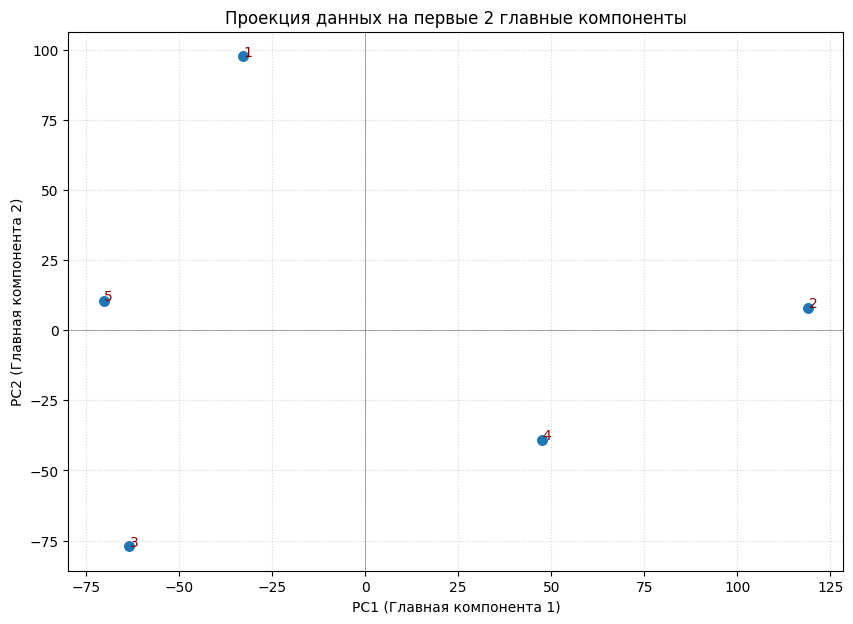

In [77]:
fig = plot_pca_projection(new_C)
plt.show()